In [1]:
import yasa
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from scipy.signal import decimate
import mne
import os
import glob

/home/jorge/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.4.1, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from initial_processes import *

In [87]:
def electrode_combinations(montage_name, neighbors_dist, long_distance, n_elect = 32):
  montage = mne.channels.read_custom_montage(montage_name)
  electrode_names = montage.ch_names[0:n_elect]
  electrode_pos = np.zeros((32,2))
  for i in np.arange(32):
    electrode_pos[i] = montage.dig[i+3].get('r')[0:2].round(3)*50 # in mm

  distances_btw_electrodes = spatial.distance.pdist(electrode_pos, 'euclidean')

  nums = np.linspace(0, n_elect-1, n_elect, dtype = int)

  comb = combinations(nums, 2)
  # working with the combination element is difficult and it can only be assigned once -> it is transformed into a list
  comb_long_distance = list(comb)

  comb = combinations(nums, 2)
  comb_short_distance = list(comb)

  # indexes for the elements to delete
  indexes_to_delete_in_short_distance = []
  indexes_to_delete_in_long_distance = []

  nei = 0
  s_d = 0
  l_d = 0

  for i in range(len(distances_btw_electrodes)):
      if distances_btw_electrodes[i] <= neighbors_dist:
          indexes_to_delete_in_long_distance.append(i)
          indexes_to_delete_in_short_distance.append(i)
          nei += 1
      elif distances_btw_electrodes[i] <long_distance:
          indexes_to_delete_in_long_distance.append(i)
          s_d += 1
      else:
          indexes_to_delete_in_short_distance.append(i)
          l_d += 1

  long_dist_electrodes = np.delete(distances_btw_electrodes, indexes_to_delete_in_long_distance)
  short_dist_electrodes = np.delete(distances_btw_electrodes, indexes_to_delete_in_short_distance)

  # when it deletes an element, it is necessary to update the indexes substracting one to the total of them the list has.
  indexes_already_del = 0
  for i in range(len(indexes_to_delete_in_long_distance)):
      del comb_long_distance[indexes_to_delete_in_long_distance[i] - indexes_already_del]
      indexes_already_del += 1

  indexes_already_del = 0
  for i in range(len(indexes_to_delete_in_short_distance)):
      del comb_short_distance[indexes_to_delete_in_short_distance[i] - indexes_already_del]
      indexes_already_del += 1

  return comb_short_distance, comb_long_distance, distances_btw_electrodes

In [4]:
ko_folder = '/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM'
wt_folder = '/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM'

In [5]:
montage_name = '/media/jorge/otherprojects/Code/coherence/EEG_Coherence/standard_32Tcm_Alfredo.elc'
#montage_name = '/media/jorge/otherprojects/Code/MNE_Alfredo/standard_32grid_Alfredo.elc'
n_electrodes = 32
neighbors_dist = 0.1
long_distance = 2

prm.set_sampling_rate(1000)
sr=prm.get_sampling_rate()
downsampling = 8
brain_state = 1 # NonREM
real_sr = sr/downsampling

### Get the files and folders to analyse

In [6]:
l_npy_files_KO = []
l_npy_files_WT = []

# dividing files by animal (KO)
os.chdir(ko_folder)
d = os.getcwd() + '/'
matching_files = glob.glob(r'*npy')
for matching_file in matching_files:
    l_npy_files_KO.append(d+matching_file)
    

# dividing files by animal (WT)
os.chdir(wt_folder)
d = os.getcwd() + '/'
matching_files = glob.glob(r'*npy')
for matching_file in matching_files:
    l_npy_files_WT.append(d+matching_file)

### Calculating the combinations for short and long distance

In [88]:
short_d_comb, long_d_comb, dist_btw_elec = electrode_combinations(montage_name, neighbors_dist, long_distance, n_electrodes)

In [95]:
np.min(dist_btw_elec)

1.2999999999999994

In [8]:
len(short_d_comb)

20

In [9]:
short_d_comb

[(0, 1),
 (0, 8),
 (2, 3),
 (3, 4),
 (5, 6),
 (6, 7),
 (9, 10),
 (11, 12),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (19, 20),
 (21, 22),
 (23, 31),
 (24, 25),
 (25, 26),
 (27, 28),
 (28, 29),
 (30, 31)]

In [10]:
#short_d_comb

In [11]:
len(long_d_comb)

476

### Calculate the spindles happening together when comparing combinations of electrodes at a short or long distance. Changes from the default. We are looking for coincidences of spindles with frequencies from 12-17 Hz with a center in 15 Hz.

In [12]:
list_sp_multi_WT = []
list_sp_WT = []
total_samples_WT = []
total_seconds_WT = []
sp_per_recording_WT = []
for i, npy_file in enumerate(l_npy_files_WT):
    # First extract data for the recording (which should be just for the NonREM state)
    raw_data = npy32mne(npy_file, montage_name, real_sr)
    total_samples_WT.append(raw_data.n_times)
    total_seconds_WT.append(raw_data.n_times/(sr/downsampling))
    # Go through all the combinations on that recording
    # Short distances
    sp_short_WT = []
    for i in list(short_d_comb): 
        data = np.vstack((raw_data._data[i[0]], raw_data._data[i[1]]))
        names = [raw_data.ch_names[i[0]],raw_data.ch_names[i[1]]]
        sp = yasa.spindles_detect(data, sf = sr/downsampling, ch_names = names, freq_sp=(12,17), multi_only=True, remove_outliers=True)
        sp_short_WT.append(sp)
        
    sp_per_recording_WT.append(list(filter(None, sp_short_WT))) # there are some sp that are empty
    # Long distance
    print('recording done:')
    print(npy_file)

Creating RawArray with float64 data, n_channels=35, n_times=1222720
    Range : 0 ... 1222719 =      0.000 ...  9781.752 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7018_D5_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1112850
    Range : 0 ... 1112849 =      0.000 ...  8902.792 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7018_D6_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1309383
    Range : 0 ... 1309382 =      0.000 ... 10475.056 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7021_D6_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1306420
    Range : 0 ... 1306419 =      0.000 ... 10451.352 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7023_D6_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1583

22-Oct-21 17:18:22 | WARNING | No spindle were found in channel V1M_LEFT.
22-Oct-21 17:18:23 | WARNING | No spindle were found in channel V1M_LEFT.
22-Oct-21 17:18:23 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
22-Oct-21 17:18:23 | WARNING | No spindles were found in data. Returning None.
22-Oct-21 17:18:25 | WARNING | No spindle were found in channel S1Tr_RIGHT.
22-Oct-21 17:18:25 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
22-Oct-21 17:18:25 | WARNING | No spindle were found in channel V1M_RIGHT.
22-Oct-21 17:18:25 | WARNING | No spindles were found in data. Returning None.
22-Oct-21 17:18:25 | WARNING | No spindle were found in channel V1M_RIGHT.
22-Oct-21 17:18:26 | WARNING | No spindle were found in channel V2L_RIGHT.
22-Oct-21 17:18:26 | WARNING | No spindle were found in channel V2ML_RIGHT.
22-Oct-21 17:18:26 | WARNING | No spindles were found in data. Returning None.
22-Oct-21 17:18:26 | WARNING | No spindle were found in channel V2ML_RIGHT.
22-Oc

recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7026_D2-A_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=829094
    Range : 0 ... 829093 =      0.000 ...  6632.744 secs
Ready.


22-Oct-21 17:18:52 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.


recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7026_D2-B_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1006817
    Range : 0 ... 1006816 =      0.000 ...  8054.528 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7026_D3_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1124351
    Range : 0 ... 1124350 =      0.000 ...  8994.800 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7030_D2_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=607895
    Range : 0 ... 607894 =      0.000 ...  4863.152 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/WTnumpy/NoREM/S7031_D2-A_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=473818
    Range : 0 ... 473817 =      0.000 ...  3790.536 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/W

#### recordings for the same animal need to be put together for doing statistical analysis

In [13]:
sp_per_animal_WT = []
files_per_animal_WT = []
seconds_animal_WT = []
sp_per_animal_WT.append(sp_per_recording_WT[1] + sp_per_recording_WT[2])
files_per_animal_WT.append(l_npy_files_WT[1] + l_npy_files_WT[2])
seconds_animal_WT.append(total_seconds_WT[1] + total_seconds_WT[2])
sp_per_animal_WT.append(sp_per_recording_WT[3])
files_per_animal_WT.append(l_npy_files_WT[3])
seconds_animal_WT.append(total_seconds_WT[3])
sp_per_animal_WT.append(sp_per_recording_WT[4])
files_per_animal_WT.append(l_npy_files_WT[4])
seconds_animal_WT.append(total_seconds_WT[4])
sp_per_animal_WT.append(sp_per_recording_WT[5] + sp_per_recording_WT[6] + sp_per_recording_WT[7])
files_per_animal_WT.append(l_npy_files_WT[5] + l_npy_files_WT[6] + l_npy_files_WT[7])
seconds_animal_WT.append(total_seconds_WT[5] + total_seconds_WT[6] + total_seconds_WT[7])
sp_per_animal_WT.append(sp_per_recording_WT[8])
files_per_animal_WT.append(l_npy_files_WT[8])
seconds_animal_WT.append(total_seconds_WT[8])
sp_per_animal_WT.append(sp_per_recording_WT[0] + sp_per_recording_WT[9])
files_per_animal_WT.append(l_npy_files_WT[0] + l_npy_files_WT[9])
seconds_animal_WT.append(total_seconds_WT[0] + total_seconds_WT[9])
sp_per_animal_WT.append(sp_per_recording_WT[10] + sp_per_recording_WT[11])
files_per_animal_WT.append(l_npy_files_WT[10] + l_npy_files_WT[11])
seconds_animal_WT.append(total_seconds_WT[10] + total_seconds_WT[11])
sp_per_animal_WT.append(sp_per_recording_WT[12] + sp_per_recording_WT[13] + sp_per_recording_WT[14])
files_per_animal_WT.append(l_npy_files_WT[12] + l_npy_files_WT[13] + l_npy_files_WT[14])
seconds_animal_WT.append(total_seconds_WT[12] + total_seconds_WT[13] + total_seconds_WT[14])
sp_per_animal_WT.append(sp_per_recording_WT[15] + sp_per_recording_WT[16] + sp_per_recording_WT[17])
files_per_animal_WT.append(l_npy_files_WT[15] + l_npy_files_WT[16] + l_npy_files_WT[17])
seconds_animal_WT.append(total_seconds_WT[15] + total_seconds_WT[16] + total_seconds_WT[17])
sp_per_animal_WT.append(sp_per_recording_WT[18])
files_per_animal_WT.append(l_npy_files_WT[18])
seconds_animal_WT.append(total_seconds_WT[18])
sp_per_animal_WT.append(sp_per_recording_WT[19])
files_per_animal_WT.append(l_npy_files_WT[19])
seconds_animal_WT.append(total_seconds_WT[19])
sp_per_animal_WT.append(sp_per_recording_WT[20])
files_per_animal_WT.append(l_npy_files_WT[20])
seconds_animal_WT.append(total_seconds_WT[19])

In [14]:
sp_per_animal_WT[0][0].summary().shape[0]

58

In [15]:
#sp_per_animal_WT[0][0].summary()

In [16]:
total_sp_animal_WT = []
comb_sp_WT = []
for record_sp in sp_per_animal_WT:
    total_record_sp = 0
    for sp_combination in record_sp:
        total_record_sp = total_record_sp + sp_combination.summary().shape[0]
        comb_sp_WT.append(sp_combination.summary().shape[0])
    
    total_sp_animal_WT.append(total_record_sp) # list with the amount of spindles per recording

total_twospindles_WT = sum(total_sp_animal_WT)
print('Total number of spindles in short distances in WT animals: ', total_twospindles_WT)

Total number of spindles in short distances in WT animals:  37297


In [17]:
total_twospindles_WT/len(sp_per_animal_WT) # spindles per animal

3108.0833333333335

In [18]:
total_twospindles_WT/sum(total_seconds_WT) # spindles per second

0.2654200683731547

In [19]:
hours_WT= sum(total_seconds_WT)/3600 # Total hours
hours_WT

39.03351333333333

In [20]:
sp_second_animal_WT = [b/m for b,m in zip(total_sp_animal_WT, seconds_animal_WT)] # spindles per second per recording

### The same for KO

In [21]:
list_sp_multi_KO = []
list_sp_KO = []
total_samples_KO = []
total_seconds_KO = []
sp_per_recording_KO = []
for i, npy_file in enumerate(l_npy_files_KO):
    # First extract data for the recording (which should be just for the NonREM state)
    raw_data = npy32mne(npy_file, montage_name, real_sr)
    total_samples_KO.append(raw_data.n_times)
    total_seconds_KO.append(raw_data.n_times/(sr/downsampling))
    # Go through all the combinations on that recording
    # Short distances
    sp_short_KO = []
    for i in list(short_d_comb): 
        data = np.vstack((raw_data._data[i[0]], raw_data._data[i[1]]))
        names = [raw_data.ch_names[i[0]],raw_data.ch_names[i[1]]]
        sp = yasa.spindles_detect(data, sf = sr/downsampling, ch_names = names, freq_sp=(12,17), multi_only=True, remove_outliers=True)
        sp_short_KO.append(sp)
    
    sp_per_recording_KO.append(list(filter(None, sp_short_KO))) # there are some sp that are empty
    # Long distance. do not do it for now, it would take too long
    print('recording done:')
    print(npy_file)

Creating RawArray with float64 data, n_channels=35, n_times=1287190
    Range : 0 ... 1287189 =      0.000 ... 10297.512 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7017_D5_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1228532
    Range : 0 ... 1228531 =      0.000 ...  9828.248 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7017_D6_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1400494
    Range : 0 ... 1400493 =      0.000 ... 11203.944 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7019_D5_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1003747
    Range : 0 ... 1003746 =      0.000 ...  8029.968 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7020_D5_Down8_nrem.npy
Creating RawArray with float64 data,

22-Oct-21 17:36:10 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
22-Oct-21 17:36:14 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.


recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7033_D3-A_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=691847
    Range : 0 ... 691846 =      0.000 ...  5534.768 secs
Ready.


22-Oct-21 17:36:34 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.


recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7033_D3-B_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=884820
    Range : 0 ... 884819 =      0.000 ...  7078.552 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7035_D2_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=961509
    Range : 0 ... 961508 =      0.000 ...  7692.064 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7035_D3_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1167327
    Range : 0 ... 1167326 =      0.000 ...  9338.608 secs
Ready.
recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7037_D2_Down8_nrem.npy
Creating RawArray with float64 data, n_channels=35, n_times=1354950
    Range : 0 ... 1354949 =      0.000 ... 10839.592 secs
Ready.
recording done:
/media/jorge/otherproj

22-Oct-21 17:40:28 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.


recording done:
/media/jorge/otherprojects/Data/Alfredo/Syngap/KOnumpy/KOnumpyNoREM/S7038_D3_Down8_nrem.npy


In [24]:
sp_per_animal_KO = []
files_per_animal_KO = []
seconds_animal_KO = []
sp_per_animal_KO.append(sp_per_recording_KO[1] + sp_per_recording_KO[2])
files_per_animal_KO.append(l_npy_files_KO[1] + l_npy_files_KO[2])
seconds_animal_KO.append(total_seconds_KO[1] + total_seconds_KO[2])
sp_per_animal_KO.append(sp_per_recording_KO[3])
files_per_animal_KO.append(l_npy_files_KO[3])
seconds_animal_KO.append(total_seconds_KO[3])
sp_per_animal_KO.append(sp_per_recording_KO[4])
files_per_animal_KO.append(l_npy_files_KO[4])
seconds_animal_KO.append(total_seconds_KO[4])
sp_per_animal_KO.append(sp_per_recording_KO[5] + sp_per_recording_KO[6])
files_per_animal_KO.append(l_npy_files_KO[5] + l_npy_files_KO[6])
seconds_animal_KO.append(total_seconds_KO[5] + total_seconds_KO[6])
sp_per_animal_KO.append(sp_per_recording_KO[7] + sp_per_recording_KO[8])
files_per_animal_KO.append(l_npy_files_KO[7] + l_npy_files_KO[8])
seconds_animal_KO.append(total_seconds_KO[7] + total_seconds_KO[8])
sp_per_animal_KO.append(sp_per_recording_KO[0] + sp_per_recording_KO[9] + sp_per_recording_KO[10])
files_per_animal_KO.append(l_npy_files_KO[0] + l_npy_files_KO[9] + l_npy_files_KO[10])
seconds_animal_KO.append(total_seconds_KO[0] + total_seconds_KO[9]  + total_seconds_KO[10])
sp_per_animal_KO.append(sp_per_recording_KO[11] + sp_per_recording_KO[12])
files_per_animal_KO.append(l_npy_files_KO[11] + l_npy_files_KO[12])
seconds_animal_KO.append(total_seconds_KO[11] + total_seconds_KO[12])
sp_per_animal_KO.append(sp_per_recording_KO[13] + sp_per_recording_KO[14])
files_per_animal_KO.append(l_npy_files_KO[13] + l_npy_files_KO[14])
seconds_animal_KO.append(total_seconds_KO[13] + total_seconds_KO[14])
sp_per_animal_KO.append(sp_per_recording_KO[15] + sp_per_recording_KO[16] + sp_per_recording_KO[17])
files_per_animal_KO.append(l_npy_files_KO[15] + l_npy_files_KO[16] + l_npy_files_KO[17])
seconds_animal_KO.append(total_seconds_KO[15] + total_seconds_KO[16]  + total_seconds_KO[17])
sp_per_animal_KO.append(sp_per_recording_KO[18] + sp_per_recording_KO[19])
files_per_animal_KO.append(l_npy_files_KO[18] + l_npy_files_KO[19])
seconds_animal_KO.append(total_seconds_KO[18] + total_seconds_KO[19])
sp_per_animal_KO.append(sp_per_recording_KO[20] + sp_per_recording_KO[21])
files_per_animal_KO.append(l_npy_files_KO[20] + l_npy_files_KO[21])
seconds_animal_KO.append(total_seconds_KO[20] + total_seconds_KO[21])
sp_per_animal_KO.append(sp_per_recording_KO[22] + sp_per_recording_KO[23])
files_per_animal_KO.append(l_npy_files_KO[22] + l_npy_files_KO[23])
seconds_animal_KO.append(total_seconds_KO[22] + total_seconds_KO[23])

In [25]:
total_sp_animal_KO = []
comb_sp_KO = []
for record_sp in sp_per_animal_KO:
    total_record_sp = 0
    for sp_combination in record_sp:
        total_record_sp = total_record_sp + sp_combination.summary().shape[0]
        comb_sp_KO.append(sp_combination.summary().shape[0])
    
    total_sp_animal_KO.append(total_record_sp) # list with the amount of spindles per recording

total_twospindles_KO = sum(total_sp_animal_KO)
print('Total number of spindles in short distances in KO animals: ', total_twospindles_KO)

Total number of spindles in short distances in KO animals:  33009


In [26]:
total_sp_animal_KO

[3553, 4680, 1293, 1438, 1352, 3656, 1278, 2338, 1260, 6734, 4332, 1095]

In [27]:
total_twospindles_KO/len(sp_per_animal_KO) # spindles per animal

2750.75

In [28]:
total_twospindles_KO/sum(total_seconds_KO) # spindles per second

0.1764479788658844

In [29]:
hours_KO=sum(total_seconds_KO)/3600 # Total hours
hours_KO

51.965268888888886

In [30]:
sp_second_animal_KO = [b/m for b,m in zip(total_sp_animal_KO, seconds_animal_KO)] # spindles per second per recording

In [31]:
#sp_second_animal_KO

Text(0, 0.5, 'spindles per second')

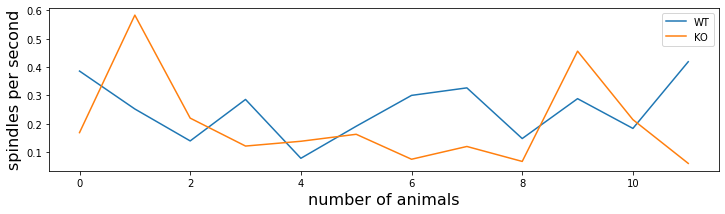

In [32]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(sp_second_animal_WT, label='WT')
ax.plot(sp_second_animal_KO, label='KO')
ax.legend(loc='upper right')
ax.set_xlabel('number of animals', fontsize=16)
ax.set_ylabel('spindles per second', fontsize=16)

In [33]:
from scipy.stats import ttest_ind

In [34]:
statistic, pvalue = ttest_ind(sp_second_animal_WT, sp_second_animal_KO)

In [35]:
pvalue

0.36654402543150655

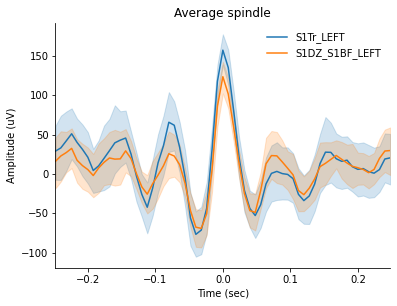

In [36]:
import seaborn as sns
# Plot an average template of the detected spindles, centered around the negative peak
ax = sp_per_animal_KO[0][0].plot_average(time_before=0.25, time_after=0.25)
ax.legend(frameon=False)
sns.despine()
os.chdir('/media/jorge/otherprojects/Data/Alfredo/')
plt.savefig("ExampleOfCoincidentSpindlesfromTwoElectrodes13to15z.pdf")

rat:  0
combination:  0
combination:  1
combination:  2
combination:  3
combination:  4
combination:  5
combination:  6
combination:  7
combination:  8
combination:  9
combination:  10
combination:  11
combination:  12
combination:  13
combination:  14
combination:  15


AssertionError: Could not calculate event-locked data.

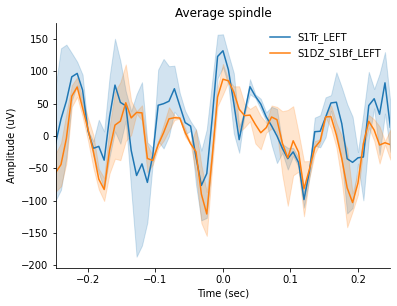

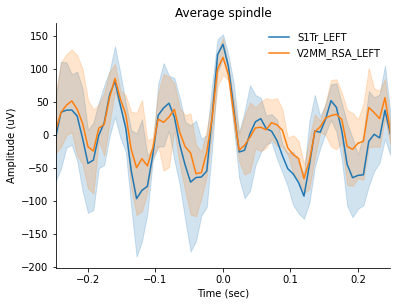

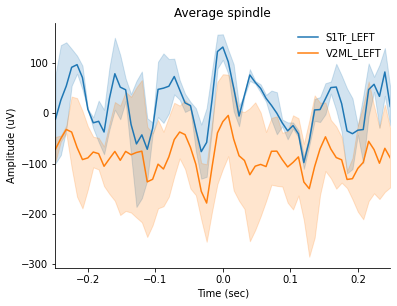

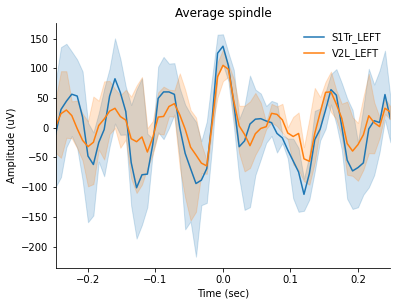

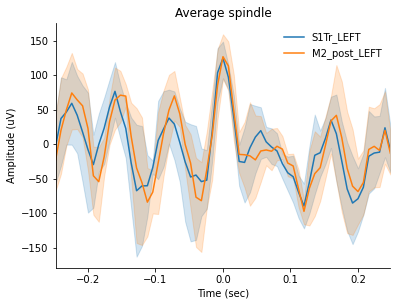

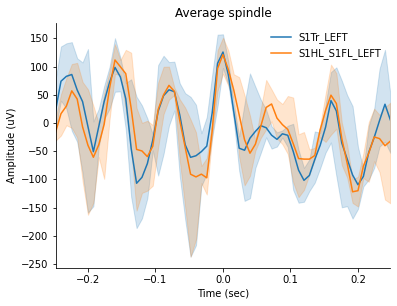

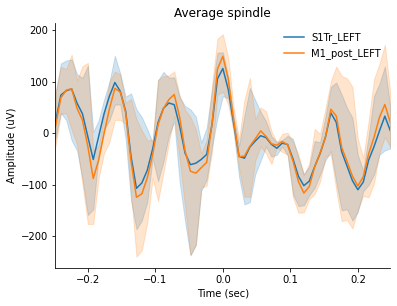

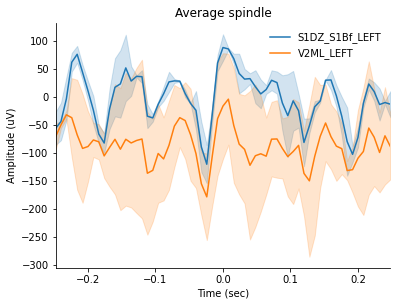

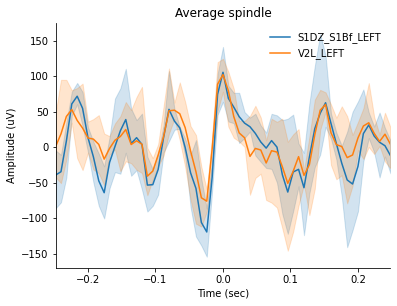

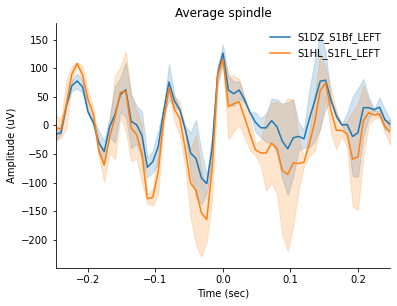

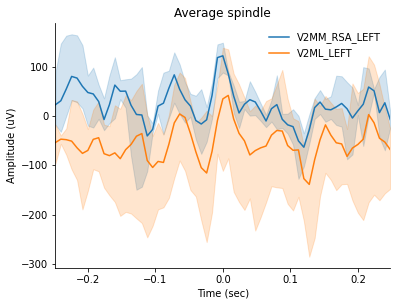

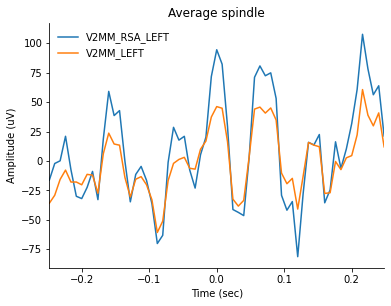

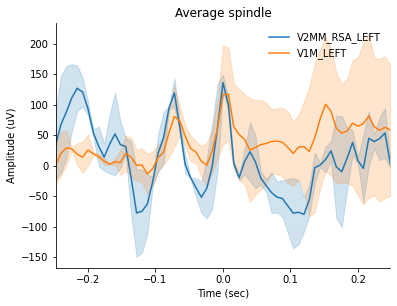

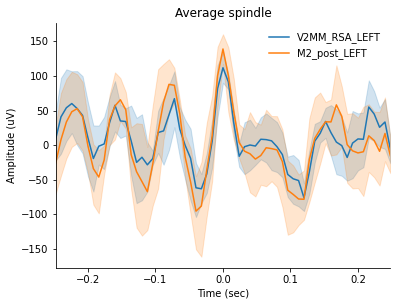

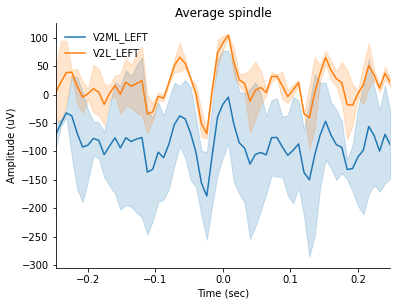

In [105]:
for rat in range(12):
    print('rat: ', rat)
    for combination in range(np.shape(sp_per_animal_KO[rat])[0]):
        print('combination: ', combination)
        ax = sp_per_animal_KO[rat][combination].plot_average(time_before=0.25, time_after=0.25)
        ax.legend(frameon=False)
        sns.despine()

### Preparing dataframes to export spindles data to excel. First with the KO.

In [37]:
list_KO = []
list_diff_KO = []
for n_animal, animal in enumerate(sp_per_animal_KO):
    for elec_tuple in animal:
        # subtracting the spindles data from one electrode to another
        n2sub = int(len(elec_tuple.summary())/2)
        if n2sub > 0:
        
            first_elec = elec_tuple.summary().head(1)['Channel'].tolist()[0]
            sec_elec = elec_tuple.summary().tail(1)['Channel'].tolist()[0]
        
            # Info about the spindles.
            df_single_sp = elec_tuple.summary().round(2)
            df_single_sp['Electrode_1'] = first_elec
            df_single_sp['Electrode_2'] = sec_elec            
            df_single_sp['Animal'] = n_animal
        
            list_KO.append(df_single_sp)
        
            # Check how different the spindles are when they are detected happening at the same time
            df_one = elec_tuple.summary().round(2).head(n2sub).iloc[:, 0:11]
            df_two = elec_tuple.summary().round(2).tail(n2sub).iloc[:, 0:11]
            df_two.reset_index(drop=True, inplace=True)
            df_diff = df_one.sub(df_two, fill_value=0)

            df_diff['Elec_1'] = first_elec
            df_diff['Elec_2'] = sec_elec
            df_diff['Animal'] = n_animal
        
            list_diff_KO.append(df_diff)

df_all_KO_spindles = pd.concat(list_KO)
df_diff_KO_spindles = pd.concat(list_diff_KO)

In [38]:
# deleting repeated spindles
df_all_KO_spindles = df_all_KO_spindles[df_all_KO_spindles.IdxChannel == 0]

# separating by animal
list_df_KO = []
list_stats_KO = []
list_stats_elec_KO = [] # list of the unique electrodes involved in each spindle cluster
list_stats_num_elec_KO = []
total_group_sp_KO = 0
total_sp_KO = 0
for n_animal, animal in enumerate(sp_per_animal_KO):
    df_for = df_all_KO_spindles[df_all_KO_spindles.Animal == n_animal]
    df_for = df_for.sort_values(by=['Peak', 'Start'])
    # defining the time distance to be in a cluster as 1 sec
    df_for['same_elec'] = df_for['Peak'] - df_for['Peak'].shift(1)     
    # when the time distance is less than 1 sec, write 0. Otherwise, 1
    df_for.fillna(0, inplace=True)
    df_for['int_elec'] = df_for['same_elec'].apply(np.floor)
    condition = [df_for['int_elec'].eq(0.0)]
    choices = [0]
    df_for['points'] = np.select(condition, choices, default=1)
    df_for['num_sp'] = df_for['points'].cumsum()
    df_for.drop(['same_elec','int_elec','points'], axis=1, inplace=True)
    stats_sp = df_for['num_sp'].value_counts().sort_index(ascending=True)
    print('Spindles clusters in animal ', n_animal, ':', df_for['num_sp'].max())
    #print('Average combinations per cluster of spindles: ' , (len(df_for.index)/df_for['num_sp'].max()).round(1))
    total_group_sp_KO = total_group_sp_KO + df_for['num_sp'].max()
    total_sp_KO = total_sp_KO + len(df_for.index)
    list_dif_elec = []
    list_num_dif_elec = []
    #finding the unique electrodes involved in each cluster of spindles
    for i in range(df_for['num_sp'].max()):
        df_comb = df_for.loc[df_for['num_sp'] == i]
        unique_elec = np.unique(df_comb[['Electrode_1', 'Electrode_2']].values)
        list_dif_elec.append(unique_elec)
        # The elements of flat_list_WT and KO contain the number of spindles per cluster. 
        # However, 1 has to be added to every element of the list because it counts ocurrences 
        # of two electrodes happening at the same time
        list_num_dif_elec.append(len(unique_elec)+1)
    print('Average number of electrodes per cluster :', np.mean(list_num_dif_elec).round(1))
    #print('SE of electrodes per cluster :', sem(list_num_dif_elec).round(1))
    
    list_stats_num_elec_KO.append(list_num_dif_elec)
    list_stats_elec_KO.append(list_dif_elec)  
    list_stats_KO.append(stats_sp)
    list_df_KO.append(df_for)

print('')
print('Clusters of spindles in the short distance Non REM (KO): ', total_group_sp_KO)
print('Total number of clusters of two spindles KO: ', total_sp_KO)
print('Number of combinations per group', (total_sp_KO/total_group_sp_KO).round(1))
flat_list_KO = [item for sublist in list_stats_num_elec_KO for item in sublist]
print('Number of electrodes per cluster in KO: ', np.mean(flat_list_KO).round(1))
print('Standard Error of electrodes per cluster in KO: ', sem(flat_list_KO).round(1))

Spindles clusters in animal  0 : 515
Average number of electrodes per cluster : 7.1
Spindles clusters in animal  1 : 406
Average number of electrodes per cluster : 10.8
Spindles clusters in animal  2 : 201
Average number of electrodes per cluster : 6.9
Spindles clusters in animal  3 : 241
Average number of electrodes per cluster : 6.5
Spindles clusters in animal  4 : 178
Average number of electrodes per cluster : 7.7
Spindles clusters in animal  5 : 467
Average number of electrodes per cluster : 7.9
Spindles clusters in animal  6 : 195
Average number of electrodes per cluster : 6.8
Spindles clusters in animal  7 : 177
Average number of electrodes per cluster : 12.0
Spindles clusters in animal  8 : 182
Average number of electrodes per cluster : 7.0
Spindles clusters in animal  9 : 694
Average number of electrodes per cluster : 9.2
Spindles clusters in animal  10 : 525
Average number of electrodes per cluster : 8.2
Spindles clusters in animal  11 : 121
Average number of electrodes per cl

### The same for WT

In [39]:
list_WT = []
list_diff_WT = []
for n_animal, animal in enumerate(sp_per_animal_WT):
    for elec_tuple in animal:
        # subtracting the spindles data from one electrode to another
        n2sub = int(len(elec_tuple.summary())/2)
        if n2sub > 0:
        
            first_elec = elec_tuple.summary().head(1)['Channel'].tolist()[0]
            sec_elec = elec_tuple.summary().tail(1)['Channel'].tolist()[0]
        
            # Info about the spindles.
            df_single_sp = elec_tuple.summary().round(2)
            df_single_sp['Electrode_1'] = first_elec
            df_single_sp['Electrode_2'] = sec_elec            
            df_single_sp['Animal'] = n_animal
        
            list_WT.append(df_single_sp)
        
            # Check how different the spindles are when they are detected happening at the same time
            df_one = elec_tuple.summary().round(2).head(n2sub).iloc[:, 0:11]
            df_two = elec_tuple.summary().round(2).tail(n2sub).iloc[:, 0:11]
            df_two.reset_index(drop=True, inplace=True)
            df_diff = df_one.sub(df_two, fill_value=0)

            df_diff['Elec_1'] = first_elec
            df_diff['Elec_2'] = sec_elec
            df_diff['Animal'] = n_animal
        
            list_diff_WT.append(df_diff)
        

df_all_WT_spindles = pd.concat(list_WT)
df_diff_WT_spindles = pd.concat(list_diff_WT)

In [40]:
# deleting repeated spindles
df_all_WT_spindles = df_all_WT_spindles[df_all_WT_spindles.IdxChannel == 0]

# separating by animal
list_df_WT = []
list_stats_WT = []
list_stats_elec_WT = [] # list of the unique electrodes involved in each spindle cluster
list_stats_num_elec_WT = []
total_group_sp_WT = 0
total_sp_WT = 0
for n_animal, animal in enumerate(sp_per_animal_WT):
    df_for = df_all_WT_spindles[df_all_WT_spindles.Animal == n_animal]
    df_for = df_for.sort_values(by=['Peak', 'Start'])
    # defining the time distance to be in a cluster as 1 sec
    df_for['same_elec'] = df_for['Peak'] - df_for['Peak'].shift(1)     
    # when the time distance is less than 1 sec, write 0. Otherwise, 1
    df_for.fillna(0, inplace=True)
    df_for['int_elec'] = df_for['same_elec'].apply(np.floor)
    condition = [df_for['int_elec'].eq(0.0)]
    choices = [0]
    df_for['points'] = np.select(condition, choices, default=1)
    df_for['num_sp'] = df_for['points'].cumsum()
    df_for.drop(['same_elec','int_elec','points'], axis=1, inplace=True)
    stats_sp = df_for['num_sp'].value_counts().sort_index(ascending=True)
    print('Spindles clusters in animal ', n_animal, ':', df_for['num_sp'].max())
    #print('Average combinations per cluster of spindles: ' , (len(df_for.index)/df_for['num_sp'].max()).round(1))
    total_group_sp_WT = total_group_sp_WT + df_for['num_sp'].max()
    total_sp_WT = total_sp_WT + len(df_for.index)
    list_dif_elec = []
    list_num_dif_elec = []
    #finding the unique electrodes involved in each cluster of spindles
    for i in range(df_for['num_sp'].max()):
        df_comb = df_for.loc[df_for['num_sp'] == i]
        unique_elec = np.unique(df_comb[['Electrode_1', 'Electrode_2']].values)
        list_dif_elec.append(unique_elec)
        # The elements of flat_list_WT and KO contain the number of spindles per cluster. 
        # However, 1 has to be added to every element of the list because it counts ocurrences 
        # of two electrodes happening at the same time
        list_num_dif_elec.append(len(unique_elec)+1)
    print('Average number of electrodes per cluster :', np.mean(list_num_dif_elec).round(1))
    #print('SE of electrodes per cluster :', sem(list_num_dif_elec).round(1))
    
    list_stats_num_elec_WT.append(list_num_dif_elec)
    list_stats_elec_WT.append(list_dif_elec)  
    list_stats_WT.append(stats_sp)
    list_df_WT.append(df_for)

print('')
print('Clusters of spindles in the short distance Non REM (WT): ', total_group_sp_WT)
print('Total number of clusters of two spindles WT: ', total_sp_WT)
print('Number of combinations per group', (total_sp_WT/total_group_sp_WT).round(1))
flat_list_WT = [item for sublist in list_stats_num_elec_WT for item in sublist]
print('Number of electrodes per cluster in WT: ', np.mean(flat_list_WT).round(1))
print('Standard Error of electrodes per cluster in WT: ', sem(flat_list_WT).round(1))

Spindles clusters in animal  0 : 863
Average number of electrodes per cluster : 8.6
Spindles clusters in animal  1 : 331
Average number of electrodes per cluster : 8.2
Spindles clusters in animal  2 : 26
Average number of electrodes per cluster : 6.8
Spindles clusters in animal  3 : 852
Average number of electrodes per cluster : 7.9
Spindles clusters in animal  4 : 39
Average number of electrodes per cluster : 9.4
Spindles clusters in animal  5 : 324
Average number of electrodes per cluster : 8.1
Spindles clusters in animal  6 : 325
Average number of electrodes per cluster : 7.7
Spindles clusters in animal  7 : 560
Average number of electrodes per cluster : 9.3
Spindles clusters in animal  8 : 369
Average number of electrodes per cluster : 7.9
Spindles clusters in animal  9 : 265
Average number of electrodes per cluster : 7.2
Spindles clusters in animal  10 : 217
Average number of electrodes per cluster : 6.8
Spindles clusters in animal  11 : 417
Average number of electrodes per cluste

In [41]:
writer = pd.ExcelWriter('spindles_last_animal.xlsx', engine='xlsxwriter')

df_for.to_excel(writer,sheet_name = 'animal_12_WT', index = False) #, startrow=20, startcol=0)
writer.save()
writer.close()

/home/jorge/miniconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [42]:
bins = np.linspace(2,32,31, dtype=int)

In [43]:
bins

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

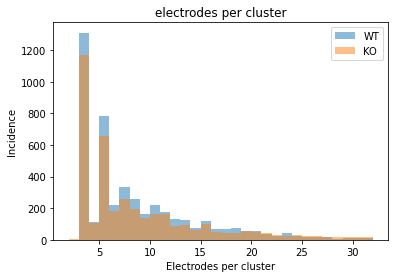

In [44]:
plt.hist(x=flat_list_WT, bins=bins, alpha=0.5, label='WT')
plt.hist(x=flat_list_KO, bins=bins, alpha=0.5, label='KO')
plt.title('electrodes per cluster')
plt.ylabel('Incidence')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper right')
os.chdir('/media/jorge/otherprojects/Data/Alfredo/')
plt.savefig("ElectrodesPerCluster13to15Hz.pdf")

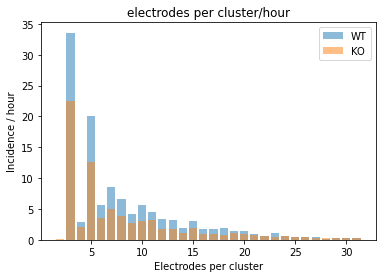

In [45]:
hist_WT, bins_WT = np.histogram(flat_list_WT, bins=bins)
plt.bar(bins_WT[:-1], hist_WT/hours_WT, alpha=0.5, label='WT')
hist_KO, bins_KO = np.histogram(flat_list_KO, bins=bins)
plt.bar(bins_KO[:-1], hist_KO/hours_KO, alpha=0.5, label='KO')
plt.title('electrodes per cluster/hour')
plt.ylabel('Incidence / hour')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper right')
plt.savefig("ElectrodesPerClusterPerHour13to15Hz.pdf")

In [46]:
statistic_cl, pvalue_clusters = ttest_ind(hist_WT/hours_WT, hist_KO/hours_KO)

In [47]:
pvalue_clusters

0.34368807826899783

### In the first 15 smaller clusters there is 90+ of the clusters

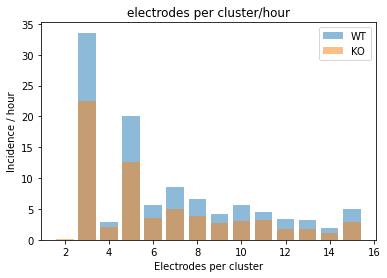

In [48]:
bins_90 = np.linspace(2,16,15, dtype=int)
hist_90_WT, bins_90_WT = np.histogram(flat_list_WT, bins=bins_90)
plt.bar(bins_90_WT[:-1], hist_90_WT/hours_WT, alpha=0.5, label='WT')
hist_90_KO, bins_90_KO = np.histogram(flat_list_KO, bins=bins_90)
plt.bar(bins_90_KO[:-1], hist_90_KO/hours_KO, alpha=0.5, label='KO')
plt.title('electrodes per cluster/hour')
plt.ylabel('Incidence / hour')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper right')
plt.savefig("ElectrodesPerClusterPerHour13to15Hz_90%.pdf")

In [49]:
statistic_cl_90, pvalue_clusters_90 = ttest_ind(hist_90_WT/hours_WT, hist_90_KO/hours_KO)
pvalue_clusters_90

0.3352444273899876

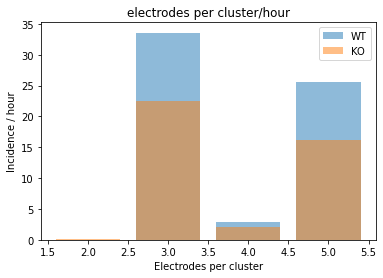

In [50]:
bins_50 = np.linspace(2,6,5, dtype=int)
hist_50_WT, bins_50_WT = np.histogram(flat_list_WT, bins=bins_50)
plt.bar(bins_50_WT[:-1], hist_50_WT/hours_WT, alpha=0.5, label='WT')
hist_50_KO, bins_50_KO = np.histogram(flat_list_KO, bins=bins_50)
plt.bar(bins_50_KO[:-1], hist_50_KO/hours_KO, alpha=0.5, label='KO')
plt.title('electrodes per cluster/hour')
plt.ylabel('Incidence / hour')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper right')
plt.savefig("ElectrodesPerClusterPerHour13to15Hz_50%.pdf")

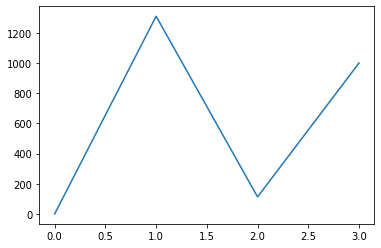

In [51]:
plt.plot(hist_50_WT)

In [52]:
statistic_cl_50, pvalue_clusters_50 = ttest_ind(hist_50_WT/hours_WT, hist_50_KO/hours_KO)
pvalue_clusters_50

0.6098575349640825

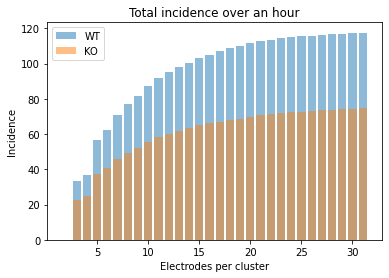

In [53]:
cumsum_WT =np.cumsum(hist_WT/hours_WT)
cumsum_KO =np.cumsum(hist_KO/hours_KO)
plt.bar(bins_WT[:-1], cumsum_WT, alpha=0.5, label='WT')
plt.bar(bins_KO[:-1], cumsum_KO, alpha=0.5, label='KO')
plt.title('Total incidence over an hour')
plt.ylabel('Incidence')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper left')
plt.savefig("AccumulativeIncidence13to15Hz.pdf")

In [54]:
cumsum_WT[len(cumsum_WT)-1]*0.9 # When 90% of the clusters are reached

105.71684810334777

In [55]:
cumsum_WT[len(cumsum_WT)-1]*0.5 # When 50% of the clusters are reached

58.73158227963765

In [56]:
cumsum_WT

array([  0.        ,  33.58652317,  36.48147139,  56.51553784,
        62.12610121,  70.65723181,  77.21569858,  81.44283536,
        87.07901774,  91.61358265,  95.02091109,  98.19766843,
       100.14471325, 103.24461356, 105.06356333, 106.83127507,
       108.72708187, 110.13612747, 111.49393504, 112.49307646,
       113.15917074, 114.26078821, 114.90126348, 115.38802468,
       115.87478589, 116.36154709, 116.56649918, 116.87392731,
       117.10449841, 117.46316456])

In [57]:
cumsum_KO[len(cumsum_KO)-1]*0.9

67.33728266627311

In [58]:
cumsum_KO

array([ 0.09621811, 22.61125604, 24.63183637, 37.2556525 , 40.73874812,
       45.72284625, 49.51383982, 52.20794692, 55.30617009, 58.46212413,
       60.15556288, 61.98370698, 63.15756793, 65.08193015, 66.00562401,
       66.87158701, 67.71830639, 68.7767056 , 69.77737396, 70.56636246,
       71.14367113, 71.66324893, 72.24055759, 72.76013539, 73.24122595,
       73.52988028, 73.83777823, 74.18416343, 74.47281776, 74.81920296])

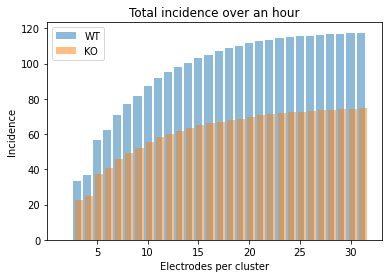

In [59]:
width = 0.2
plt.bar(bins_WT[:-1], cumsum_WT, alpha=0.5, label='WT')
plt.bar(bins_KO[:-1]+ width, cumsum_KO, alpha=0.5, label='KO')
plt.title('Total incidence over an hour')
plt.ylabel('Incidence')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper left')
plt.savefig("ElectrodesPerCluster_v2_13to15Hz.pdf")

In [60]:
print(seconds_animal_WT)
print(seconds_animal_KO)

[19377.864, 10451.36, 1266.592, 23682.096, 4863.16, 13572.304, 8449.64, 16175.863999999998, 19637.856, 6598.04, 7682.472, 7682.472]
[21032.208, 8029.976, 5876.648, 11821.36, 9761.439999999999, 22412.304000000004, 16997.712, 19453.951999999997, 18669.832000000002, 14770.632000000001, 20178.216, 18070.688000000002]


In [61]:
hours_animal_WT = [round(seconds/3600, 2) for seconds in seconds_animal_WT]
hours_animal_KO = [round(seconds/3600, 2) for seconds in seconds_animal_KO]
print(hours_animal_WT)
print(hours_animal_KO)

[5.38, 2.9, 0.35, 6.58, 1.35, 3.77, 2.35, 4.49, 5.45, 1.83, 2.13, 2.13]
[5.84, 2.23, 1.63, 3.28, 2.71, 6.23, 4.72, 5.4, 5.19, 4.1, 5.61, 5.02]


In [62]:
bins = 4 #np.array([8,16,24,32])

In [63]:
bins = np.linspace(2,16,16, dtype=int)

In [64]:

#doing histogram, animal by animal
hists_WT = []
hists_KO = []
for animal_n, elecs_cl in enumerate(list_stats_num_elec_WT):
    hist_n, bins_n = np.histogram(elecs_cl, bins=bins)
    hists_WT.append((hist_n/hours_animal_WT[animal_n]).round(2))

for animal_n, elecs_cl in enumerate(list_stats_num_elec_KO):
    hist_n, bins_n = np.histogram(elecs_cl, bins=bins)
    hists_KO.append((hist_n/hours_animal_KO[animal_n]).round(2))


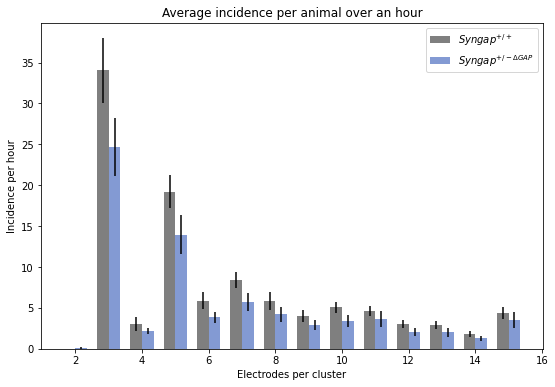

In [65]:
width = 0.35
hists_KO_np = np.vstack(hists_KO)
mean_hists_KO = np.mean(hists_KO_np, axis=0)
sem_hists_KO = sem(hists_KO_np, axis=0)
hists_WT_np = np.vstack(hists_WT)
sem_hists_WT = sem(hists_WT_np, axis=0)
mean_hists_WT = np.mean(hists_WT_np, axis=0)

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(bins[:-1]-width/2, mean_hists_WT, width, yerr=sem_hists_WT, alpha=0.5, color = 'black', label = '$Syngap^{+/+}$')
ax.bar(bins[:-1]+width/2, mean_hists_KO, width, yerr=sem_hists_KO, alpha=0.5, color = '#0836a9', label = '$Syngap^{+/-\u0394 GAP}$')
ax.set_title('Average incidence per animal over an hour')
ax.set_ylabel('Incidence per hour')
ax.set_xlabel('Electrodes per cluster')
ax.legend(loc='upper right')
plt.savefig("AverageIncidencePerAnimalOverAnHour13to15Hz.pdf")

In [66]:
l_pvalues = []

statistic_cl, pvalue_clusters = ttest_ind(hist_WT/hours_WT, hist_KO/hours_KO)

In [67]:
np.size(hists_KO_np[0][:])

15

In [68]:
hists_KO_t = np.transpose(hists_KO_np)
hists_WT_t = np.transpose(hists_WT_np)

In [69]:
np.shape(hists_WT)[1]

15

In [70]:
hists_WT[1][:15]

array([ 0.  ,  0.  , 39.66,  1.38, 17.24,  2.41,  9.66,  4.14,  2.76,
        4.83,  3.45,  3.45,  3.79,  1.72,  6.9 ])

In [71]:
np.shape(hists_WT[1])

(15,)

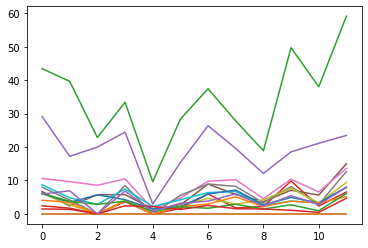

In [72]:
plt.plot(hists_WT)

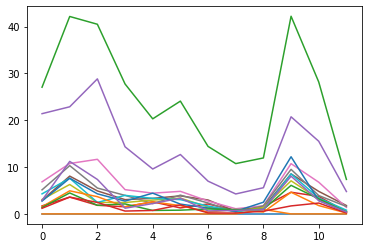

In [73]:
plt.plot(hists_KO)

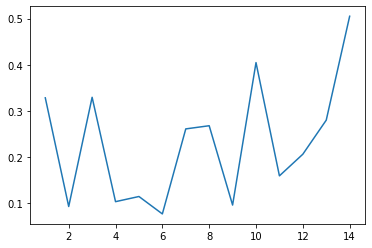

In [74]:
l_pvalues = []
for cluster in np.arange(np.shape(hists_WT)[1]):
    stat_cl, pv = ttest_ind(hists_KO_t[cluster], hists_WT_t[cluster])
    l_pvalues.append(pv)

plt.plot(l_pvalues)
    

In [75]:
l_pvalues

[nan,
 0.3281832618806706,
 0.09272189573108248,
 0.3293422085953066,
 0.10322220763689957,
 0.11441071213555778,
 0.07668621800295303,
 0.2608780010174132,
 0.26774252338974025,
 0.09588470660510034,
 0.4045084500177163,
 0.15915873983775802,
 0.20603029208586165,
 0.2798296731686186,
 0.504944272422817]

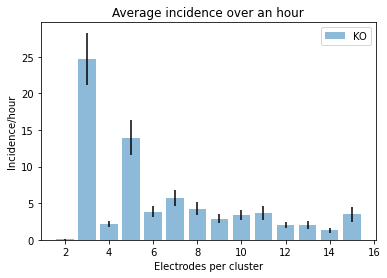

In [76]:
plt.bar(bins[:-1], mean_hists_KO, yerr=sem_hists_KO, alpha=0.5, label='KO')
plt.title('Average incidence over an hour')
plt.ylabel('Incidence/hour')
plt.xlabel('Electrodes per cluster')
plt.legend(loc='upper right')

In [77]:
mean_hists_WT

array([ 0.        ,  0.        , 34.04583333,  3.0675    , 19.20833333,
        5.90583333,  8.39583333,  5.86583333,  4.00833333,  5.08916667,
        4.59833333,  3.01583333,  2.94      ,  1.82916667,  4.34166667])

In [78]:
sem_hists_WT

array([0.        , 0.        , 3.93703347, 0.85326212, 2.01228569,
       1.03670183, 0.97776528, 1.1221418 , 0.77798967, 0.65490163,
       0.589117  , 0.48957226, 0.51409526, 0.34563174, 0.73958817])

In [79]:
os.chdir('/media/jorge/otherprojects/Data/Alfredo/')

In [80]:
writer = pd.ExcelWriter('spindles_NoREM_Real_dist_short_Dist2_from_npy_12-17Hz.xlsx', engine='xlsxwriter')

df_all_KO_spindles.to_excel(writer,sheet_name = 'shortKO', index = False) #, startrow=20, startcol=0)
df_all_WT_spindles.to_excel(writer,sheet_name = 'shortWT', index = False) #, startrow=20, startcol=0)
writer.save()
writer.close()

/home/jorge/miniconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [81]:
df_all_WT_sp_without_repeat = df_all_WT_spindles[df_all_WT_spindles.IdxChannel == 0]
df_all_KO_sp_without_repeat = df_all_KO_spindles[df_all_KO_spindles.IdxChannel == 0]

In [82]:
df_all_WT_sp_without_repeat.head(20)

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel,Electrode_1,Electrode_2,Animal
0,281.57,281.70,282.16,0.59,144.30,31.09,3.04,0.30,13.62,8.0,0.21,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
1,462.03,462.38,462.64,0.61,156.72,28.47,2.91,0.32,14.23,6.0,0.56,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
2,785.33,785.42,785.97,0.64,167.73,38.98,3.07,0.27,14.26,8.0,0.14,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
3,1464.34,1464.94,1465.04,0.70,161.22,29.93,2.74,0.28,13.14,8.0,0.85,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
4,1522.34,1522.58,1523.15,0.81,173.68,37.60,3.07,0.37,13.43,9.0,0.28,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
5,3101.78,3102.22,3102.48,0.70,125.41,26.71,2.73,0.25,12.92,8.0,0.62,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
6,3635.12,3635.29,3635.66,0.54,164.89,33.30,2.95,0.38,14.79,5.0,0.30,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
7,4225.92,4226.08,4226.55,0.63,193.11,48.15,3.31,0.36,13.55,7.0,0.25,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
8,4350.65,4351.02,4351.32,0.67,122.80,25.67,2.61,0.29,13.06,8.0,0.55,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0
9,4661.16,4661.54,4661.81,0.65,198.00,41.22,3.08,0.27,13.70,8.0,0.57,S1Tr_LEFT,0,S1Tr_LEFT,S1DZ_S1BF_LEFT,0


In [83]:
writer = pd.ExcelWriter('diff_spindles_Real_dist_short_Dist2_from_npy_12-17H.xlsx', engine='xlsxwriter')

df_diff_KO_spindles.to_excel(writer,sheet_name = 'shortKO', index = False) #, startrow=20, startcol=0)
df_diff_WT_spindles.to_excel(writer,sheet_name = 'shortWT', index = False) #, startrow=20, startcol=0)
writer.save()
writer.close()

/home/jorge/miniconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [84]:
os.getcwd()

'/media/jorge/otherprojects/Data/Alfredo'